<a href="https://colab.research.google.com/github/ArpitKadam/Attention-Is-All-You-Code/blob/main/LLM-from-Scratch/CHP_12_Entire_LLM_Pre_training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREVIOUSLY**

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
        GELU(),
        nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
    )

  def forward(self, x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, drop_rate, num_heads, qkv_bias):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(drop_rate)
    self.register_buffer("simple_mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    batch, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = torch.matmul(queries, keys.transpose(2, 3))

    attn_scores.masked_fill_(
        self.simple_mask.bool()[:num_tokens, :num_tokens],
        -torch.inf
    )

    attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)

    attn_weights = self.dropout(attn_weights)

    context_vec = torch.matmul(attn_weights, values)

    context_vec = context_vec.transpose(1, 2)

    context_vec = context_vec.contiguous().view(batch, num_tokens, self.d_out)

    context_vec = self.out_proj(context_vec)

    return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        context_length = cfg['context_length'],
        num_heads = cfg['n_heads'],
        qkv_bias = cfg['qkv_bias'],
        drop_rate = cfg['drop_rate']
      )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg['emb_dim'])
    self.norm2 = LayerNorm(cfg['emb_dim'])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    ## Connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    ## Conection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

class GPT_MODEL(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_out = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
    )

    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
    batch_size, seq_length = x.shape

    token_embeddings = self.token_emb(x)
    pos_embeddings = self.pos_emb(torch.arange(seq_length, device=x.device))

    x = token_embeddings + pos_embeddings
    x = self.drop_out(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):

    idx_crop = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_crop)

    logits = logits[:, -1, :]

    probas = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

model = GPT_MODEL(GPT_CONFIG_124M)
model.eval()        ## Use to disable dropout during inference

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  token_list = token_ids.squeeze(0).tolist()
  decoded_text = tokenizer.decode(token_list)
  return decoded_text

In [2]:
with open("/content/the-verdict.txt", "r") as file:
  text_data = file.read()

import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataSetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    for i in range(0, len(token_ids) - max_length, stride):
      ## Here max_length is the context_size
      input_chunk = token_ids[i: i + max_length]
      target_chunk = token_ids[i+1: i + max_length + 1]

      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, index):
    return self.input_ids[index], self.target_ids[index]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPTDataSetV1(txt, tokenizer, max_length, stride)

  dataloader = DataLoader(
      dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers
  )

  return dataloader

train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=256, stride=256)
val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=256, stride=256)

In [3]:
def cal_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    ## Reduce the number of batches to match the total number of batches in dataloader
    ## i.e if num_batches exceeds the number of the batches in data_loader
    num_batches = min(num_batches, len(data_loader))

  for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
    if batch_idx < num_batches:
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT_MODEL(GPT_CONFIG_124M).to(device)

torch.manual_seed(123)

with torch.no_grad():
  loss_train = cal_loss_loader(train_loader, model, device)
  loss_val = cal_loss_loader(val_loader, model, device)

print(f"Train Loss: {loss_train}")
print(f"Val Loss: {loss_val}")

Train Loss: 10.998041868209839
Val Loss: 10.979731559753418


# **TRAINING LOOP FOR THE LLM**

In [11]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = cal_loss_loader(train_loader, model, device, eval_iter)
    val_loss = cal_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model, encoded, 50, context_size)
  decoded = token_ids_to_text(token_ids, tokenizer)
  print(decoded.replace("\n", " "))
  model.train()

In [12]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

  ## Initialize list to track losses and tokens seen
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  ## Main Training Loop
  for epoch in range(num_epochs):
    model.train()     ## set model to training mode

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()    ## Resests loss gradients from from previous batch iteration
      loss = cal_loss_batch(input_batch, target_batch, model, device)
      loss.backward()     ## Calculate loss gradients
      optimizer.step()    ## Calculate model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1

      ## Optional Evaluation Step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch+1}, Step: {global_step:06d} Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    generate_and_print_sample(model, tokenizer, device, start_context)

  return train_losses, val_losses, track_tokens_seen

In [15]:
import time
start_time = time.time()

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT_MODEL(GPT_CONFIG_124M).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 15
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5,
    start_context="I glanced after him", tokenizer=tokenizer
)

end_time = time.time()
total_time_in_min = (end_time - start_time) / 60
print(f"Total Training Time: {total_time_in_min:.2f} minutes")

Epoch: 1, Step: 000000 Train Loss: 9.768, Val Loss: 10.079
Epoch: 1, Step: 000005 Train Loss: 8.086, Val Loss: 8.354
I glanced after him,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch: 2, Step: 000010 Train Loss: 6.722, Val Loss: 7.227
Epoch: 2, Step: 000015 Train Loss: 5.916, Val Loss: 6.822
I glanced after him, the,, and, and,, the,,, the,,,, the,,, the, and,,,, the,,,, and,, the,,, the,, the,, and, the
Epoch: 3, Step: 000020 Train Loss: 6.795, Val Loss: 8.205
I glanced after him, and, and, and, and, and the fact, and in the, and--and, and the of the of the, and the, and, and, and, and the of the of the of the of the of the of
Epoch: 4, Step: 000025 Train Loss: 5.136, Val Loss: 6.775
Epoch: 4, Step: 000030 Train Loss: 4.592, Val Loss: 6.764
I glanced after him, and he had been.                                            
Epoch: 5, Step: 000035 Train Loss: 3.996, Val Loss: 6.694
I glanced after him.  "Oh, and he was his pictures--and the.       "Oh, and in him. "Oh, and he ha

# **VISUALIZATION**

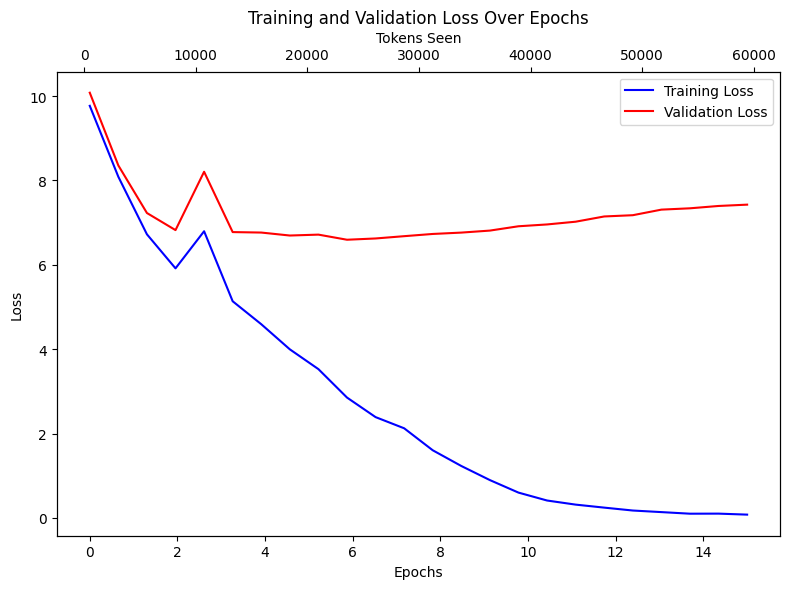

In [16]:
from numpy import integer
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(8, 6))

  ## Plot Training and Validation Loss against epochs
  ax1.plot(epochs_seen, train_losses, label="Training Loss", color="blue")
  ax1.plot(epochs_seen, val_losses, label="Validation Loss", color="red")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.set_title("Training and Validation Loss Over Epochs")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ## Create a second x-axis for tokens seen
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, label="Training Loss", color="blue", linestyle="--", alpha=0)
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout()
  plt.savefig('loss-plot.png')
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)